In [ ]:
#Importing All Necessary Libraries:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.models as models
from torchvision.models import resnet18
from tqdm import tqdm #Using this library for progress bar.
from torch.optim.lr_scheduler import StepLR #For Learning Rate Scheduler.

In [ ]:
#Need to determine whether to run the training on GPU or CPU based on computer's conditions.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#Defining Hyperparameters:
numEpochs = 30
batchSize = 64
learningRate = 0.001

In [ ]:
#Loading the CIFAR-10 Dataset:

#Need to preprocess the image using transformations (convert to Tensor format + normalize image) --> ONLY FOR TRAINING DATASET.
trainingTransformations = transforms.Compose([ #.Compose allows me to chain multiple transformations together.
    transforms.RandomHorizontalFlip(), #Will randomly flip the images horizontally. These 2 transformations will increase the variability of the training data.
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    #.Normalize helps in standardizing the input data and makes the model flexible to different lighting conditions.
])

testingTransformations = transforms.Compose([ #Transformations for the testing data.
    transforms.ToTensor()
])

trainingDataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=trainingTransformations)

100%|██████████| 170498071/170498071 [00:03<00:00, 45214984.74it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
#Splitting Dataset:

trainSize = int(0.8 * len(trainingDataset)) #80% for training & 20% is the validation dataset.
validationSize = len(trainingDataset) - trainSize

trainingDataset, validationDataset = torch.utils.data.random_split(trainingDataset, [trainSize, validationSize])

testingDataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=testingTransformations)

Files already downloaded and verified


In [ ]:
#Creating the Data Loaders:
trainingLoader = torch.utils.data.DataLoader(trainingDataset, batch_size=batchSize, shuffle=True) #The number of batches in the training dataset.
validationLoader = torch.utils.data.DataLoader(validationDataset, batch_size=batchSize, shuffle=False)
testingLoader = torch.utils.data.DataLoader(testingDataset, batch_size=batchSize, shuffle=False)

In [ ]:
#Using a pre-defined model (Resnet-18):
model = resnet18(weights = None, num_classes = 10)
#Since I'm importing a model, it will use the pre-trained weights of the ResNet-18 architecture, but will adapt the output layer to have 10 classes for the CIFAR-10 dataset.

In [ ]:
#Loss Function, Model Optimizer and Learning Rate Scheduler:
lossCriterion = nn.CrossEntropyLoss() #This loss function will allow me calculate the cross-entropy loss between the model's predicted classes & the actual class labels (from dataset).
#I'm using the CrossEntropyLoss because it is suitable for multi-class classification tasks as such and will calculate the loss based on the predicted & true class labels.

modelOptimizer = optim.Adam(model.parameters(), lr = learningRate, weight_decay = 0.0001) #This optimizer function will allow me to adjust the network's parameters (weights & biases) to minimize the loss function.
#The Adam (Adaptive Moment Estimation) optimizer is adaptive that maintains per-paramater learning rates and incorportes momentum & adaptive learning rate scaling.

#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-5)

scheduler = optim.lr_scheduler.StepLR(modelOptimizer, step_size=10, gamma=0.1) #Learning rate scheduler will multiply the LR by 0.1 per 10 epochs (hence, DECREASING IT).

In [ ]:
#Training Loop:
totalSteps = len(trainingLoader) #Total number of steps per epoch.
trainingLosses = [] #Stores the training losses for each epoch during each loop. Allows us to track and visualize the train loss over epochs.
validationLosses = [] #These arrays are going to be used for visualization purposes.

for epoch in range(numEpochs):
    runningLoss = 0.0 #Initializing the running loss for the current epoch.
    model.train() #Setting the model to training mode (.train() comes from PyTorch) in order to apply training-specific behaviours.
    with tqdm(total=len(trainingLoader), desc=f'Epoch {epoch + 1}/{numEpochs}', unit='batch') as progressBar:
      for i, (images, labels) in enumerate(trainingLoader):
          #Performing a forward pass:
          outputs = model(images) #Computing the predicted outputs for the current batch in the current epoch.
          loss = lossCriterion(outputs, labels)

          #Performing a backward pass and optimizing:
          modelOptimizer.zero_grad() #Clearing the gradients from the previous iteration.
          loss.backward() #Doing a backpropagation (backward pass) to compute the gradients.
          modelOptimizer.step() #Updating the model's paramaters based upon the computed gradients.

          runningLoss += loss.item() #Accumulating and updating the running loss for the current batch.
          progressBar.set_postfix({'Loss': loss.item()})
          progressBar.update(1) #Updates progress bar after each unit (in this case after 1 batch iteration).

      trainingLoss = runningLoss/len(trainingLoader) #Computing the average training loss for the epoch.
      trainingLosses.append(trainingLoss)


      #Validation:
      model.eval() #Setting the model to evaluation mode.
      validationLoss = 0.0

      with torch.no_grad():
          correctValidation = 0
          totalValidations = 0
          for images, labels in validationLoader:
              outputs = model(images) #Computing the predicted outputs for the validation set.
              loss = lossCriterion(outputs, labels) #Computing the loss once again between the predicted ouputs & actual labels.
              validationLoss += loss.item() #Accumulating the validation loss per batch.

              _, predicted = torch.max(outputs.data, 1)
              totalValidations += labels.size(0)
              correctValidation += (predicted == labels).sum().item()

      validationLoss /= len(validationLoader) #Calculating the average validation loss.
      validationLosses.append(validationLoss)
      validationAccuracy = (correctValidation)/(totalValidations) * 100  #Calculating the validation accuracy.

      scheduler.step() #Adjusting the learning rate.

      #Printing the loss information for the current epoch:
      progressBar.set_postfix({"Epoch": epoch+1, "Training Loss": f"{trainingLoss: .4f}", "Validation Loss": f"{validationLoss: .4f}", "Validation Accuracy": f"{validationAccuracy:.2f}%"})
      progressBar.update(1)


#Evaluation:
model.eval()
numberOfCorrect = 0
totalAmount = 0

with torch.no_grad():
    for images, labels in testingLoader:
        outputs = model(images) #Computing the predicted outputs for the testing set.
        _, predicted = torch.max(outputs.data, 1) #Getting the predicted labels from the output of the model.
        #torch.max() returns both the max values and their corresponding indices along a specified dimension.
        #We care about max values in dimension 1 --> represents CLASS PROBABILITIES.
        #Assigning them to predicted allows us to compare with actual label to evaluate model accuracy.

        totalAmount += labels.size(0) #Accumulating the total number of labels.
        #labels.size(0) returns the size of the "labels" tensor along the dimension 0 --> represents BATCH SIZE.

        numberOfCorrect += (predicted == labels).sum().item() #Counting the number of correct predictions.
        #predicted == labels is a tensor of booleans indicating which predictions are correct.
        #We sum this tensor and call .item() to obtain correct predictions as a scalar value.

testAccuracy = (numberOfCorrect/totalAmount) * 100
print(f'Test Accuracy: {testAccuracy:.2f}%')

Epoch 1/30: 626batch [08:34,  1.22batch/s, Epoch=1, Training Loss=1.5963, Validation Loss=1.3942, Validation Accuracy=49.03%]
Epoch 2/30: 626batch [08:49,  1.18batch/s, Epoch=2, Training Loss=1.2581, Validation Loss=1.1575, Validation Accuracy=58.75%]
Epoch 3/30: 626batch [12:33,  1.20s/batch, Epoch=3, Training Loss=1.1033, Validation Loss=1.0544, Validation Accuracy=62.47%]
Epoch 4/30: 626batch [12:27,  1.19s/batch, Epoch=4, Training Loss=1.0026, Validation Loss=1.0623, Validation Accuracy=63.32%]
Epoch 5/30: 626batch [12:27,  1.19s/batch, Epoch=5, Training Loss=0.9227, Validation Loss=0.9240, Validation Accuracy=67.67%]
Epoch 6/30: 626batch [12:26,  1.19s/batch, Epoch=6, Training Loss=0.8672, Validation Loss=0.8721, Validation Accuracy=69.42%]
Epoch 7/30: 626batch [12:26,  1.19s/batch, Epoch=7, Training Loss=0.8106, Validation Loss=0.9289, Validation Accuracy=68.93%]
Epoch 8/30: 626batch [12:33,  1.20s/batch, Epoch=8, Training Loss=0.7766, Validation Loss=0.8158, Validation Accuracy=

Test Accuracy: 82.70%


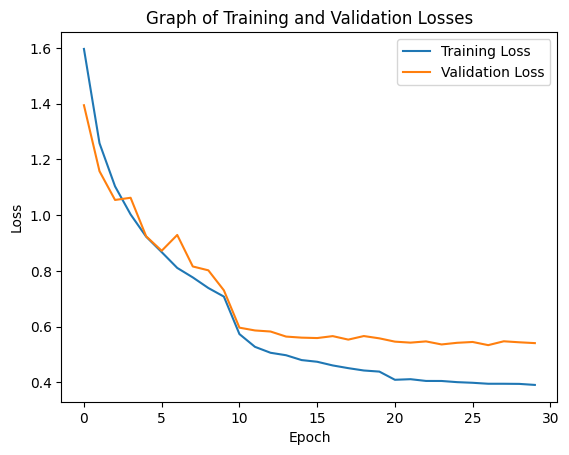

In [ ]:
#Plotting Training and Validation Losses (using Matplotlib.Pyplot):
plt.plot(range(numEpochs), trainingLosses, label = "Training Loss") #Plotting the training losses over epochs.
plt.plot(range(numEpochs), validationLosses, label = "Validation Loss") #Plotting the validation losses over epochs.
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Graph of Training and Validation Losses")
plt.legend()
plt.show()